<h1 style="text-align: center; vertical-align: middle;">Numerical Methods of Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture by Dr. Adrian Oeftiger</h2>

<img src="./img/etit.png" style="width: 20%; margin: auto;" />

<h3 style="text-align: center; vertical-align: middle;">Part 8: 16.12.2022</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
1. via the public mybinder.org service: <br />

<p style="text-align: center; margin-left, margin-right: auto; width: 100%;">
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-08/v1.0"><img src="./img/binder_logo.svg" /></a>
</p>
</div>

<div class="alert alert-block alert-success" style="text-align:center;">
2. on the <a href="https://tu-jupyter-i.ca.hrz.tu-darmstadt.de/">local TU Darmstadt jupyterhub $\nearrow$</a> (using your TU ID)

$\implies$ make sure you installed all the required python packages (see the [README](./README.md))!
</div>

Finally, also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-08/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-08).

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config import (np, plt, Madx, interp1d, PyNAFF,
                    pysixtrack, elements,
                    M_drift, M_dip_x, M_dip_y, 
                    M_quad_x, M_quad_y, 
                    track, track_sext_4D)
%matplotlib inline

<h2 style="color: #b51f2a">Refresher!</h2>

- magnetic fields for bending particles
- multipole representation (normal and skew coefficients $b_n,a_n$)
- dipole, quadrupole, sextupole fields
- <b>e</b>quation <b>o</b>f <b>m</b>otion in magnetic fields (after paraxial approximation)
- Hill differential equation
- betatron matrices for transport (solution to e.o.m.)
---
- drifts: divergence
- dipoles: bending included in Frenet-Serret coordinate system, (weak) geometric focusing
- quadrupoles: focus in one plane while defocusing in the other
- FODO cells: alternating-gradient configuration stabilising both transverse planes
- FODO lattice instability for too strong quadrupoles
- sextupoles, non-linearity and deterministic chaos

<h2 style="color: #b51f2a">In the video for today!</h2>

1. Hill Differential Equation & Floquet Theory
2. Twiss Parametrisation and Optics
3. The FODO Cell
4. Off-momentum Particles: Dispersion & Chromaticity

<h2 style="color: #b51f2a">Exercises today!</h2>

1. Basics:<br />
    a) compute Twiss parameters<br />
    b) compare tracking with betatron and Twiss matrix<br />
    c) determining tune from tracking data vs. phase advance<br />
2. Periodic Transport Matrices<br />
---
3. Optics of a FODO Cell<br />
---
4. Dispersion Function of a FODO Cell<br />
5. Dispersion in Tracking<br />
6. Chromaticity in Tracking<br />
7. Chromatic Detuning in a FODO Cell from Tracking Data<br />
8. <i>Bonus:</i> Chromaticity Correction with Sextupoles

<!--<div style="text-align: center; width:100%;">
    <h2>Part I: Hill Differential Equation & Floquet Theory</h2>
</div>-->

<div style="text-align: center; width:100%;">
    <h2>Part II: Twiss Parametrisation and Optics</h2>
</div>

The Twiss matrix for a periodic lattice with local Twiss parameters $\beta_x, \alpha_x, \gamma_x$ (here for the horizontal plane $x$) reads

$$\mathcal{M}_{\text{period,tw,}x} = \begin{pmatrix}\,
    \cos(\Phi_x) + \alpha_x\sin(\Phi_x) & \beta_x \sin(\Phi_x) \\
    -\gamma_x \sin(\Phi_x) & \cos(\Phi_x) - \alpha_x\sin(\Phi_x)
\end{pmatrix}$$

with the identity $\beta_x\gamma_x = 1+\alpha_x$!

Between two locations $s_0$ and $s_1$, the solution of the Hill differential equation can be expressed in terms of the phase advance $\Delta \psi_x$ and the corresponding local Twiss parameters, $(\beta_x,\alpha_x,\gamma_x)$ at $s_0$ and $s_1$, respectively.

$$\mathcal{M}_{\text{tw,}x}\bigr|_{s_1\leftarrow s_0} = \underbrace{\begin{pmatrix}\,
    \frac{1}{\sqrt{\beta_{x1}}} & 0 \\
    \frac{\alpha_{x1}}{\sqrt{\beta_{x1}}} & \sqrt{\beta_{x1}}
\end{pmatrix}^{-1}}\limits_{\mathop{\doteq} F_1{}^{-1}} \cdot
\underbrace{\begin{pmatrix}
    \cos(\Delta \psi_x) & \sin(\Delta \psi_x) \\
    -\sin(\Delta \psi_x) & \cos(\Delta \psi_x)
\end{pmatrix}}\limits_{\mathop{\doteq} R} \cdot
\underbrace{\begin{pmatrix}
    \frac{1}{\sqrt{\beta_{x0}}} & 0 \\
    \frac{\alpha_{x0}}{\sqrt{\beta_{x0}}} & \sqrt{\beta_{x0}}
\end{pmatrix}}\limits_{\mathop{\doteq}F_0}$$

Here, $F$ denotes the Floquet transformation matrix (from physical phase space $x-x'$ to normalised phase space $\eta-\eta'$) and $R\in\mathrm{SO}(2)$ a rotation matrix.

### Exercise 1a: Compute Twiss Parameters

Use the Methodical Accelerator Design (MAD-X) code to compute the optical Twiss functions *):

<i>*) (behind the scene the code works very similar to what we discussed in the lecture video, Twiss parametrisation of the full-period matrix and transport thereof via betatron matrices)</i>

In [2]:
madx = Madx(stdout=True)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.12.16 12:42:33      +
  ++++++++++++++++++++++++++++++++++++++++++++


Define the following periodic beam line of $10\,$m length:
    
- focusing quadrupole centred at 3m (strength $k=0.1\,$m${}^{-2}$ and length $L=0.6\,$m)
- dipole sector bend centred at 5m (bending angle $\theta=\pi/8$ and length $L=0.6\,$m)
- defocusing quadrupole centred at 7m (strength $k=-0.5\,$m${}^{-2}$ and length $L=0.4\,$m)

In [3]:
madx.input('''
k1l_f := 0.1 * 0.6;  // inverse focal length qf
k1l_d := -0.5 * 0.4; // inverse focal length qd

qf: quadrupole, l = 0.6, k1 := k1l_f / 0.6;
qd: quadrupole, l = 0.4, k1 := k1l_d / 0.4;
dip: sbend, l = 0.6, angle := pi / 8;

seq1: sequence, l = 10;
qf, at = 3;
dip, at = 5;
qd, at = 7;
endsequence;
''')

True

In [4]:
madx.command.beam(particle='proton', energy=1) # energy is in GeV!
madx.use(sequence='seq1')

# output the Twiss parameters every 0.1m
madx.command.select(flag="interpolate", sequence="seq1", step=0.1)

True

Now we compute the periodic solution to the Hill equation (in terms of the Twiss parameters):

In [5]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0      0.09572878063        3.232054955 

                q1                dq1            betxmax              dxmax 
      0.2393933525      -0.4979445041        11.70243519        7.345182369 

             dxrms             xcomax             xcorms                 q2 
       6.588466214                  0                  0       0.2224798695 

               dq2            betymax              dymax              dyrms 
     -0.1070464578        11.39223223                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

Let us investigate the optical functions along this periodic beam line: (red areas mark quadrupoles, gray areas mark dipoles)

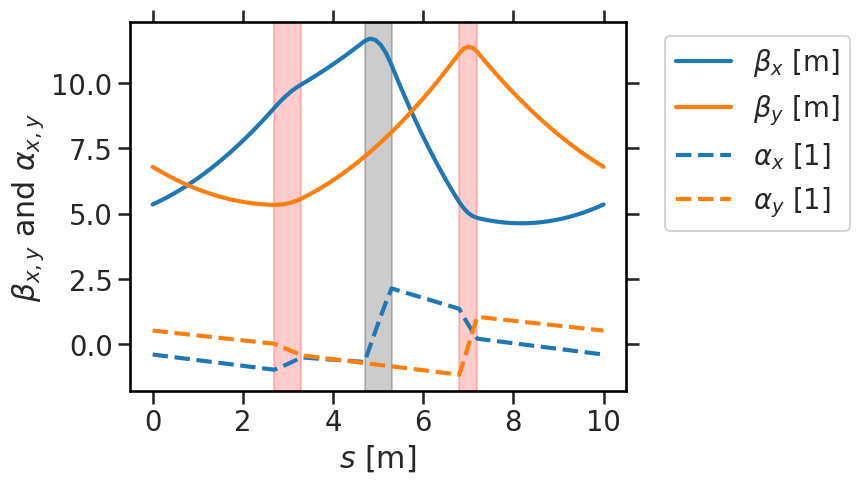

In [6]:
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$ [m]')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$ [m]')
plt.plot(twiss['s'], twiss['alfx'], label=r'$\alpha_x$ [1]', c='C0', ls='--')
plt.plot(twiss['s'], twiss['alfy'], label=r'$\alpha_y$ [1]', c='C1', ls='--')

ylim = plt.ylim()
plt.fill_betweenx(ylim, 3-0.3, 3+0.3, color='red', alpha=0.2)
plt.fill_betweenx(ylim, 7-0.2, 7+0.2, color='red', alpha=0.2)
plt.fill_betweenx(ylim, 5-0.3, 5+0.3, color='black', alpha=0.2)
plt.ylim(ylim)

plt.xlabel('$s$ [m]')
plt.ylabel(r'$\beta_{x,y}$ and $\alpha_{x,y}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

$\implies$ periodic functions, right values at $s=10\,$m are equal to left values at $s=0\,$m!

<p style="color:#e6541a;">$\implies$ note what happens to the $\beta_{x,y}$ functions at the locations of the quadrupoles (red areas)! Do you understand the direction into which the $\beta$-functions turn?</p>

<p style="color:#e6541a;">$\implies$ note what happens to the optics inside the dipole (gray area)! Do you understand why only the horizontal plane is affected and how it is affected?</p>

### Exercise 1b: Compare Tracking with Twiss and Betatron Matrices

We provide interpolation functions for any position $s$ given the MAD-X computed Twiss table $s-\beta_{x,y}-\alpha_{x,y}-\psi_{x,y}$:

In [7]:
beta_x = interp1d(twiss['s'], twiss['betx'], kind='linear')
alpha_x = interp1d(twiss['s'], twiss['alfx'], kind='linear')
psi_x = interp1d(twiss['s'], 2 * np.pi * twiss['mux'], kind='linear')

Define the Floquet transformation matrix and the rotation matrix for the Twiss transport matrix:

In [8]:
def F(beta, alpha):
    '''Floquet transformation matrix to normalised phase space.'''
    return np.array([
        [1 / np.sqrt(beta), 0],
        [alpha / np.sqrt(beta), np.sqrt(beta)]
    ])

def R(angle):
    '''Rotation matrix.'''
    return np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])

def M_tw(beta0, alpha0, beta1, alpha1, delta_psi):
    '''Transport matrix with Twiss parameters from index 0 to 1.'''
    F0 = F(beta0, alpha0)
    F1 = F(beta1, alpha1)
    F1inv = np.linalg.inv(F1)
    Rot = R(delta_psi)
    return F1inv.dot(Rot.dot(F0))

Prepare the tracking of a particle along this periodic beam line: once with betatron matrices for each element, once with the Twiss matrix!

In [9]:
# path length positions at edges of elements
s = [0, 3 - 0.6/2, 3 + 0.6/2, 5 - 0.6/2, 5 + 0.6/2, 7 - 0.4/2, 7 + 0.4/2, 10]
ds = np.diff(s)

In [10]:
# betatron matrices
d1 = M_drift(ds[0])
qf = M_quad_x(ds[1], 0.1)
d2 = M_drift(ds[2])
dip = M_dip_x(ds[3], 0.6 / (np.pi / 8)) # rho0 = L / angle
d3 = M_drift(ds[4])
qd = M_quad_x(ds[5], -0.5)
d4 = M_drift(ds[6])

In [11]:
# Twiss transport matrix
def M_tw_s0to1_x(s0, s1):
    '''Twiss matrix from s0 to s1 (evaluating Twiss parameters at these points!).'''
    return M_tw(
        beta_x(s0), alpha_x(s0), 
        beta_x(s1), alpha_x(s1), 
        psi_x(s1) - psi_x(s0)
    )

The initial horizontal coordinates of the particle at $s=0\,$m:

In [12]:
x_ini = 0.02
xp_ini = 0.01

Some plotting helper functions:

In [13]:
def scatter(s, x, label=None):
    plt.scatter([s], [x], c='red', s=30, marker='D', label=label)

def scatter_tw(s, x, label=None):
    plt.scatter([s], [x], c='cyan', s=40, marker='.', label=label)

Go for the tracking!

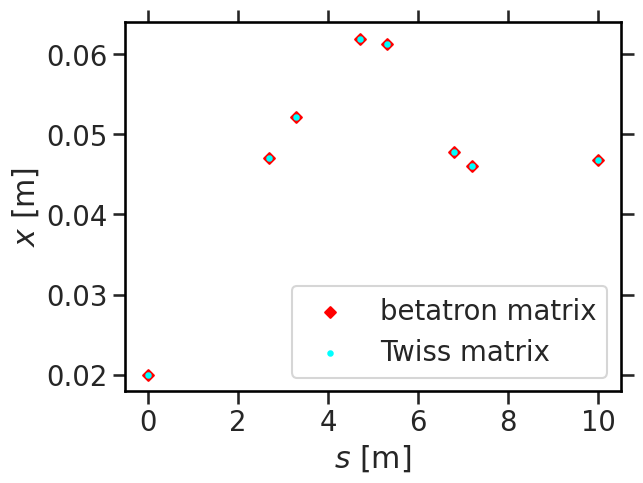

In [14]:
# track with betatron matrices from one element to the next:
scatter(0, x_ini, label='betatron matrix')

x, xp = track(d1, x_ini, xp_ini)
scatter(s[1], x)

x, xp = track(qf, x, xp)
scatter(s[2], x)

x, xp = track(d2, x, xp)
scatter(s[3], x)

x, xp = track(dip, x, xp)
scatter(s[4], x)

x, xp = track(d3, x, xp)
scatter(s[5], x)

x, xp = track(qd, x, xp)
scatter(s[6], x)

x, xp = track(d4, x, xp)
scatter(s[7], x)

# track with the Twiss transport matrix
scatter_tw(0, x_ini, label='Twiss matrix')
xt, xpt = x_ini, xp_ini
for i in range(len(s) - 1):
    M_tw_x = M_tw_s0to1_x(s[i], s[i + 1])
    xt, xpt = track(M_tw_x, xt, xpt)
    scatter_tw(s[i + 1], xt)

plt.xlabel('$s$ [m]')
plt.ylabel('$x$ [m]')
plt.legend();

$\implies$ the <span style='color:red;'>transfer maps via the Twiss parameters</span> $\beta_x(s), \alpha_x(s), \gamma_x(s)$ are <span style='color:red;'>identical to</span> the element-by-element <span style='color:red;'>betatron matrices</span> from the previous lecture! <b>Both correctly describe the solution to the equation of motion (<i>Hill differential equation!</i>)</b>.

$\implies$ the advantage with $\mathcal{M}_\text{tw}$: only require one single matrix to describe solution at any location $s$! (Need to determine the optics functions / Twiss parameters before!)

<p style="color:#e6541a;">$\implies$ are betatron matrices and the Twiss matrix still identical in case of an unstable lattice?</p>

### Exercise 1c: Determine the Tune from Tracking and Compare to Computed Phase Advance

Let us track a particle with the compiled betatron matrix for a number of periods. We can determine the tune via Discrete Frequency Analysis (NAFF) and then compare to the phase advance computed via the Twiss matrix approach:

In [15]:
M_period = qf.dot(d1)
M_period = d2.dot(M_period)
M_period = dip.dot(M_period)
M_period = d3.dot(M_period)
M_period = qd.dot(M_period)
M_period = d4.dot(M_period)

We need to record the oscillation for a useful number of turns:

In [16]:
nperiods = 128

In [17]:
rec_x = np.zeros(nperiods, dtype=float)
rec_x[0] = x_ini

Tracking:

In [18]:
x, xp = x_ini, xp_ini
for i in range(1, nperiods):
    x, xp = track(M_period, x, xp)
    rec_x[i] = x

The horizontal motion looks as follows:

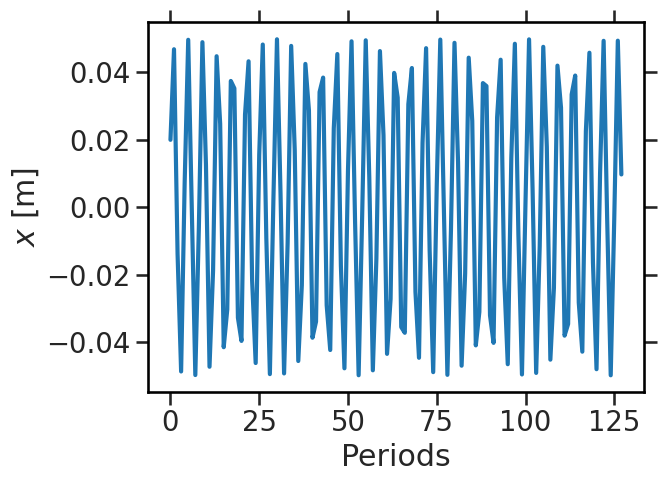

In [19]:
plt.plot(rec_x)
plt.xlabel('Periods')
plt.ylabel('$x$ [m]');

We determine the tune via the `PyNAFF` library which implements the Numerical Analysis of Fundamental Frequencies algorithm (cf. lecture 02):

In [20]:
tune = PyNAFF.naff(rec_x, turns=nperiods, nterms=1)[0, 1]
tune

0.23933457593486843

$\implies$ this is the tune of the particle (number of oscillations per period) measured via tracking data!

Now what about the phase advance from the full-period transfer matrix, $2\cos(\Phi_x)=\mathrm{Tr}(\mathcal{M})$ ?

In [21]:
trace = np.matrix.trace(M_period)

np.arccos(trace / 2)

1.504152795201079

Convert from phase advance to tune units by dividing by $2\pi$:

In [22]:
np.arccos(trace / 2) / (2 * np.pi)

0.239393352521743

$\implies$ the particle follows the same frequency as determined via the Twiss matrix approach!

By the way, the phase advance or rather tune $Q=\psi\,/\,2\pi$ was also computed by MAD-X:

In [23]:
twiss.summary['q1']

0.2393933525

### Exercise 2: Periodic Transport Matrices

Consider the following numerical (horizontal) transport matrices, each for a full period of a lattice.

<p style="color:#e6541a;">Can you determine:</p>

<p style="color:#e6541a;">
a) whether they are valid transport matrices (symplecticity)?<br />
b) whether they provide stable transport?<br />
c) the covered phase advance $\Phi_x$ per lattice period (and the tune $Q_x=\Phi_x\,/\,2\pi$)?<br />
b) the local Twiss parameters $\beta_x, \alpha_x$?
</p>

<p style="color:#e6541a;">
How do the eigenvalues represent stability and phase advance? (check absolute values and complex phases, picture on the unit circle)</p>

<i>Hint: you might need the following functions for a given matrix `M`:</i>

- determinant: `np.linalg.det(M)`
- trace: `np.matrix.trace(M)`
- eigenvalues: `np.linalg.eigvals(M)`
- arccos: `np.arccos(...)`
- sin: `np.sin(...)`
- absolute value: `np.abs(...)`
- phase $\phi$ (radiant units) from complex number $e^{i\phi}$: `np.angle(...)`
- matrix multiplication $M_1\cdot M_2$: `np.dot(M1, M2)` or `M1.dot(M2)`

$$\mathcal{M}_1 = \begin{pmatrix}
    -0.03701215 &  0.19960535 \\
    -5.04003498 &  0.16259319
\end{pmatrix}$$

In [24]:
M1 = np.array([
    [-0.03701215,  0.19960535],
    [-5.04003498,  0.16259319]
])

$$\mathcal{M}_2 = \begin{pmatrix}
    0.5 &  13 \\
    -0.0961538 &  -0.5
\end{pmatrix}$$

In [25]:
M2 = np.array([
    [0.5,  13],
    [-0.09615385,  -0.5]
])

<p style="color:#e6541a;">$\implies$ what happens to particles in this lattice after a short number of lattice periods? (Investigate by applying the transport matrix repetetively.)</p>

$$\mathcal{M}_3 = \begin{pmatrix}
    0.31803855 &  22.193583 \\
    -0.1533821 &  0.93858321
\end{pmatrix}$$

In [26]:
M3 = np.array([
    [0.31803855,  22.193583],
    [-0.1533821,  0.93858321]
])

$$\mathcal{M}_4 = \begin{pmatrix}
    -0.75105652 &  0.69069571 \\
    -0.02118063 &  -1.31197933
\end{pmatrix}$$

In [27]:
M4 = np.array([
    [-0.75105652,  0.69069571],
    [-0.02118063, -1.31197933]
])

<div style="text-align: center; width:100%;">
    <h2>Part III: The FODO Cell</h2>
</div>

### Exercise 3: Computing Optics of a FODO cell

Consider a $110\,$m long FODO cell with $3.3\,$m long quadrupole magnets. A possible implementation might look like this (blue: LHC dipoles, white: LHC quadrupoles):

<img src="img/lhc-fodo.jpg" alt="Arc section with FODO cells in the LHC" style="width:60%; margin:auto; margin-top:1em;" />

<p style="clear: both; font-size: 10pt; text-align: right; float: right;">image by <a href="http://archive.boston.com/bigpicture/2009/11/large_hadron_collider_ready_to.html#photo22">CERN</a></p>

Here is the layout of the FODO cell (as in the previous lecture notebook):

<img src="img/lhc-cell.png" alt="LHC cell layout" style="width: 80%;" />

<p style="clear: both; font-size: 10pt; text-align: right; float: right;">image by <a href="https://indico.hep.manchester.ac.uk/getFile.py/access?resId=8&materialId=slides&confId=5922">G. Xia</a></p>

We start with a non-bending FODO cell, i.e. the dipoles switched off. 

Let us determine the optical functions, again via MAD-X:

In [28]:
madx = Madx(stdout=True)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.12.16 12:42:35      +
  ++++++++++++++++++++++++++++++++++++++++++++


We define the FODO cell with two quadrupoles of opposite strength, $k\cdot L=0.008\cdot 3.3\,$m${}^{-1}$, and with three dipoles in between each quadrupole. For the moment the dipoles are switched off (their bending angle $\theta=0$):

In [29]:
madx.input('''
k1l_f := 0.008 * 3.3;  // inverse focal length qf
k1l_d := -0.008 * 3.3; // inverse focal length qd
theta := 0;            // in LHC: 2 * pi / 1232;

qf2: quadrupole, l = 3.3 / 2, k1 := k1l_f / 3.3; // half a focusing quad
qd:  quadrupole, l = 3.3,     k1 := k1l_d / 3.3;
dip: sbend, l = 14.3, angle := theta;

fodo: sequence, l = 110;
qf2, at = 3.3 / 4;
dip, at = 12; 
dip, at = 2 * 110 / 8; 
dip, at = 110 / 2 - 12; 
qd, at = 110 / 2;
dip, at = 110 / 2 + 12; 
dip, at = 6 * 110 / 8; 
dip, at = 110 - 12; 
qf2, at = 110 - 3.3 / 4;
endsequence;
''')

True

In [30]:
madx.command.beam(particle='proton', energy=7e3) # energy is in GeV!
madx.use(sequence='fodo')

# output the Twiss parameters every 1m
madx.command.select(flag="interpolate", sequence="fodo", step=1)

True

We call the Twiss routine to compute the optics:

In [31]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               110                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2518947018      -0.3220961047        186.9084848                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2518947018 

               dq2            betymax              dymax              dyrms 
     -0.3220961047        186.4581481                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

Save some values for this FODO cell for later:

In [32]:
madx.input('value, beam->beta;')

beam->beta         =        0.999999991 ;


True

In [33]:
qx_fodo = twiss.summary['q1']
qpx_fodo = twiss.summary['dq1'] * 0.999999991

The optics of this FODO cell looks as follows:

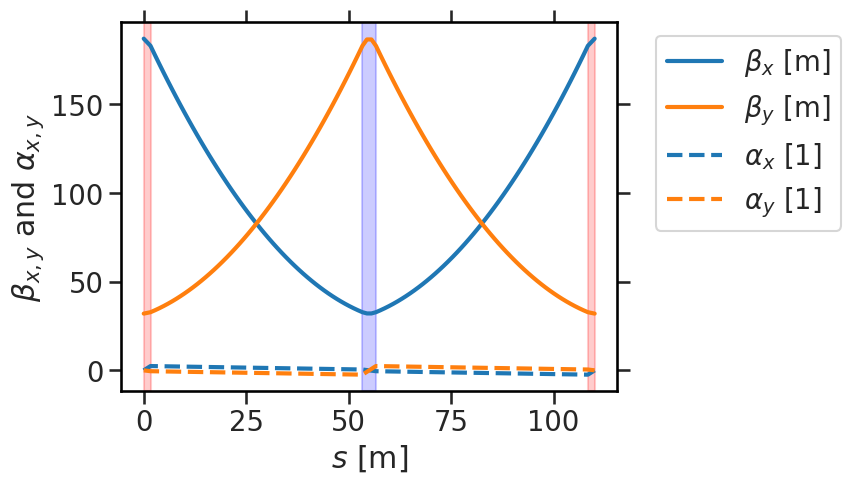

In [34]:
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$ [m]')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$ [m]')
plt.plot(twiss['s'], twiss['alfx'], label=r'$\alpha_x$ [1]', c='C0', ls='--')
plt.plot(twiss['s'], twiss['alfy'], label=r'$\alpha_y$ [1]', c='C1', ls='--')

ylim = plt.ylim()
plt.fill_betweenx(ylim, 0, 3.3/2, color='red', alpha=0.2)
plt.fill_betweenx(ylim, 110/2 - 3.3/2, 110/2 + 3.3/2, color='blue', alpha=0.2)
plt.fill_betweenx(ylim, 110 - 3.3/2, 110, color='red', alpha=0.2)
plt.ylim(ylim)

plt.xlabel('$s$ [m]')
plt.ylabel(r'$\beta_{x,y}$ and $\alpha_{x,y}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

<p style="color:#e6541a;"> $\implies$ can you identify where the maximum and minimum of the $\beta$-functions is located? Can you explain the alternating-gradient focusing concept in terms of the $\beta$-functions?</p>

<div style="text-align: center; width:100%;">
    <h2>Part IV: Off-momentum Particles, Dispersion & Chromaticity</h2>
</div>

<h2>Dispersion</h2>

Dispersion describes the effect of dipole fields on off-momentum particles with $\delta\neq 0$.

The dispersion function $D(s)$ satisfies the inhomogeneous Hill differential equation

$$D'' + \left(\frac{1}{\rho_0(s)} + k(s)\right)\cdot D = \frac{1}{\rho_0(s)}$$

and exists only for finite bending radius $\rho_0(s)$ somewhere along the path length $s$ (i.e. when dipole fields are present!).

### Exercise 4: Computing the Dispersion Function of a FODO cell

For illustration, we use again the LHC FODO cell, but now we switch on the dipole magnets:

In [35]:
madx.input('theta := 2 * pi / 1232;')

++++++ info: theta redefined


True

Let us recompute the optics functions, as this time also the dispersion function will assume finite values (<span style="color: #e6541a;">$\implies$ why?</span>):

In [36]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               110                 -0    0.0004388874913        47.73351305 

                q1                dq1            betxmax              dxmax 
      0.2519723158      -0.3218296078        186.8781443        2.249453549 

             dxrms             xcomax             xcorms                 q2 
       1.634089545                  0                  0       0.2518947018 

               dq2            betymax              dymax              dyrms 
     -0.3218849941        186.4581481                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

The dispersion function describes the local horizontal offset due to a momentum deviation $\delta=\Delta p/p_0$ with respect to the synchronous reference particle:

$$x_\text{disp}(s) = D_x(s) \cdot \delta$$

$D_x(s)$ hence encodes the change of the (horizontal) closed orbit (along which the reference particle travels) for a particle with twice the reference momentum.

In [37]:
madx.input('value, beam->beta;')

beam->beta         =        0.999999991 ;


True

Text(0, 0.5, '$D_x(s)$ [m]')

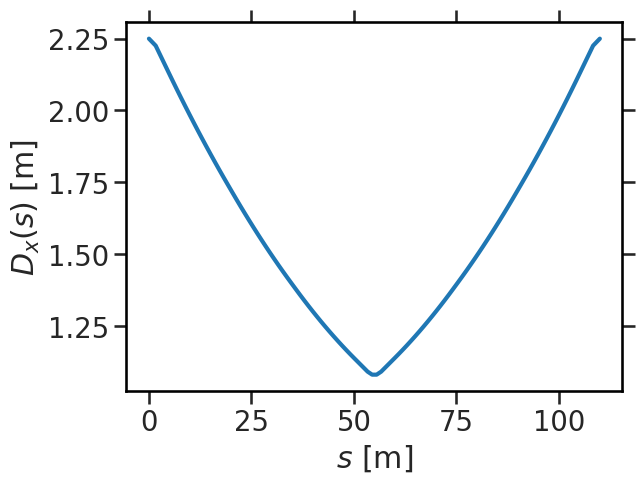

In [38]:
plt.plot(twiss['s'], twiss['dx'] * 0.999999991)
plt.xlabel('$s$ [m]')
plt.ylabel('$D_x(s)$ [m]')

$\implies$ Dispersion function $D(s)$ is focused by the quadrupoles in a similar way as the horizontal $\beta_x(s)$-function!

<p style="color: #e6541a;">$\implies$ verify that the dispersion is generated by the dipole magnets! (What does this mean?) How does the dispersion function $D(s)$ look like when the dipole fields are switched off?</p>

### Exercise 5: Dispersion Effect in Tracking

To illustrate the dispersion effect, we use the thin-lens tracking code PySixTrack (like our thin-lens betatron matrices but for 6D, i.e. including the momentum deviation $\delta$)!

We define a drift of $5\,$m length and a dipole with a bending angle of $0.1\,$rad:

In [39]:
drift = elements.DriftExact(5)
dipole = elements.Multipole(knl=[0.1], hxl=0.1)

Initialise two particles, both at $x=0.04\,$m but only one at a momentum deviation of $\delta=10^{-3}$:

In [40]:
part0 = pysixtrack.Particles(x=0, delta=0)
part1 = pysixtrack.Particles(x=0, delta=0.001)

Track through the drift, then the dipole and again the drift:

In [41]:
rec_x0 = [part0.x]
rec_x1 = [part1.x]

drift.track(part0)
drift.track(part1)

rec_x0 += [part0.x]
rec_x1 += [part1.x]

dipole.track(part0)
dipole.track(part1)

rec_x0 += [part0.x]
rec_x1 += [part1.x]

drift.track(part0)
drift.track(part1)

rec_x0 += [part0.x]
rec_x1 += [part1.x]

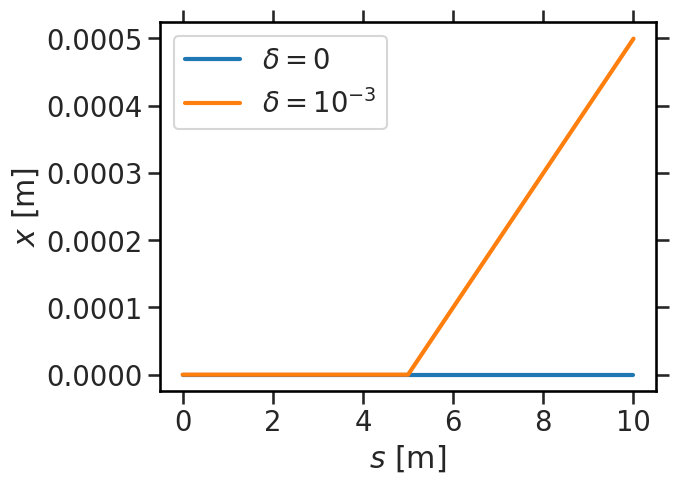

In [42]:
plt.plot([0, 5, 5, 10], rec_x0, label='$\delta=0$')
plt.plot([0, 5, 5, 10], rec_x1, label='$\delta=10^{-3}$')

plt.xlabel('$s$ [m]')
plt.ylabel('$x$ [m]')
plt.legend();

<p style="color: #e6541a;">$\implies$ can you explain what happens here and why?</p>

<!-- fodo cell tracking with pysixtrack for delta=0 and finite delta -->

### Exercise 6: Chromaticity Effect in Tracking

Chromaticity describes the focusing change for off-momentum particles. 

Quadrupoles focus less for higher-momentum particles $\delta>0$ and thus the tune $Q$ decreases. The chromaticity can be defined as

$$Q'=\frac{dQ}{d\delta}$$

and the natural chromaticity of a magnetic lattice is thus negative.

Let us illustrate by tracking particles in PySixTrack again. We define a quadrupole with an integrated focusing strength of $k\cdot L=0.3\,$m${}^{-1}$:

In [43]:
quad = elements.Multipole(knl=[0, 0.3])

<p style="color: #e6541a;">$\implies$ what is the expected focal length $f$?</p>

Initialise two sets of particles with the same distribution in $x$, one of which features a momentum deviation of $\delta=0.1$ (!):

<p style="color: #e6541a;">$\implies$ what is the expected focal length change $\Delta f(\delta)$ for these $\delta=0.1$ particles?</p>

In [44]:
npart = 11
x_dist = np.linspace(-0.05, 0.05, npart)

In [45]:
part0 = pysixtrack.Particles(x=x_dist.copy(), delta=0)
part1 = pysixtrack.Particles(x=x_dist.copy(), delta=0.1)

Track through the $5\,$m drift, then through the quadrupole and again through the same drift:

In [46]:
rec_x0 = [part0.x.copy()]
rec_x1 = [part1.x.copy()]

drift.track(part0)
drift.track(part1)

rec_x0 += [part0.x.copy()]
rec_x1 += [part1.x.copy()]

quad.track(part0)
quad.track(part1)

rec_x0 += [part0.x.copy()]
rec_x1 += [part1.x.copy()]

drift.track(part0)
drift.track(part1)

rec_x0 += [part0.x.copy()]
rec_x1 += [part1.x.copy()]

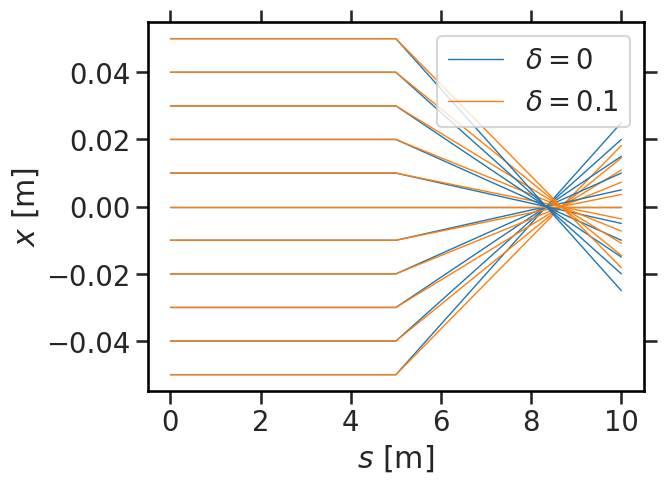

In [47]:
for i in range(npart):
    l0, = plt.plot([0, 5, 5, 10], np.array(rec_x0)[:, i], c='C0', lw=1)
    l1, = plt.plot([0, 5, 5, 10], np.array(rec_x1)[:, i], c='C1', lw=1)

plt.xlabel('$s$ [m]')
plt.ylabel('$x$ [m]')
plt.legend([l0, l1], ['$\delta=0$', '$\delta=0.1$']);

$\implies$ we observe less focusing for $\delta>0$ particles $\leadsto$ less phase advance in quasi-harmonic oscillation $\leadsto$ negative tune shift!

<h2>Natural Chromaticity of a FODO Cell</h2>

Can derive expression for natural chromaticity of a FODO cell with phase advance $\Phi_\text{FODO}$ via thin-lens approximation:
    
$$Q'_\text{FODO} = -\frac{1}{\pi}\tan\left(\frac{\Phi_\text{FODO}}{2}\right)$$

Natural chromaticity is always negative (<span style="color: #e6541a;">$\implies$ why?</span>).

### Exercise 7: Chromatic Detuning in a FODO Cell from Tracking

Let us track with PySixTrack through the LHC FODO cell for a distribution of particles with momentum spread and observe the chromatic tune shift.

We first define the same FODO cell as in MAD-X before (just in thin-lens approximation and without dipoles):

In [48]:
kL = 0.008 * 3.3

qf2_fodo = elements.Multipole(knl=[0, kL / 2.])
qd_fodo = elements.Multipole(knl=[0, -kL])
drift_fodo = elements.DriftExact(110 / 2.)

fodo = [qf2_fodo, drift_fodo, qd_fodo, drift_fodo, qf2_fodo]

We initialise a distribution of `npart` macro-particles, with a momentum spread between $\delta\in[-10^{-3},10^{-3}]$ at a fixed initial horizontal position of $x=0.04\,$m:

In [49]:
npart = 21
x_ini = 0.04
delta = np.linspace(-0.001, 0.001, npart)

particles = pysixtrack.Particles(x=x_ini, delta=delta)

We will record the $x$ position after each FODO cell for each particle:

In [50]:
ncells = 1024

rec_x = np.zeros((ncells, npart), dtype=float)
rec_x[0] = particles.x

Let's go for the tracking:

In [51]:
for i in range(1, ncells):
    for el in fodo:
        el.track(particles)
    rec_x[i] = particles.x

Comparing two particles with same initial $x$ but different $\delta$, we already see the different phase advance in the recorded horizontal motion:

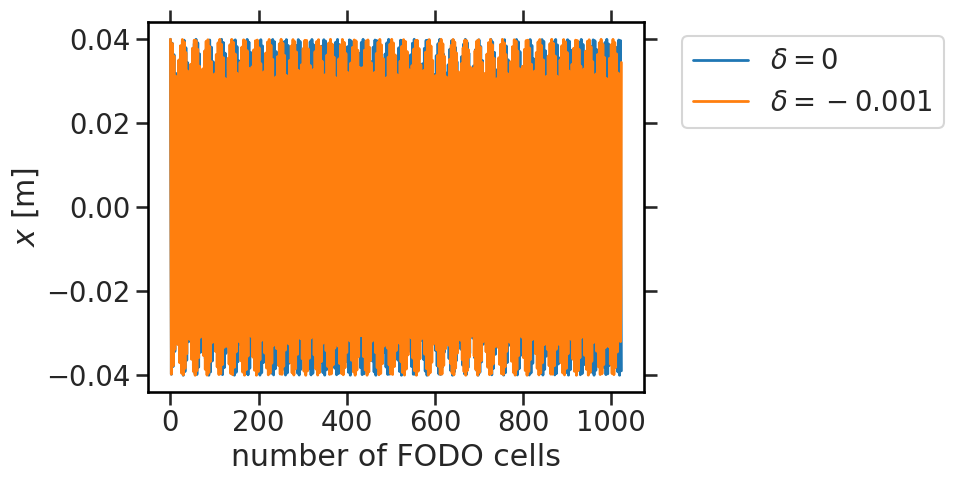

In [52]:
plt.plot(rec_x[:, npart//2 + 1], lw=2, label='$\delta=0$')
plt.plot(rec_x[:, 0], lw=2, label='$\delta=-0.001$')

plt.xlabel('number of FODO cells')
plt.ylabel('$x$ [m]')
plt.legend(bbox_to_anchor=(1.05, 1));

Let's evaluate the tune of each particle using the NAFF algorithm:

In [53]:
Qx_delta = np.zeros(npart, dtype=float)

for i in range(npart):
    Qx_delta[i] = PyNAFF.naff(rec_x[:, i], turns=ncells, nterms=1)[0, 1]

The tune of the $\delta=0$ particle should be the tune of the reference particle in this linear lattice:

In [54]:
Qx_delta[npart//2 + 1]

0.2585892190147631

In [55]:
qx_fodo

0.2518947018

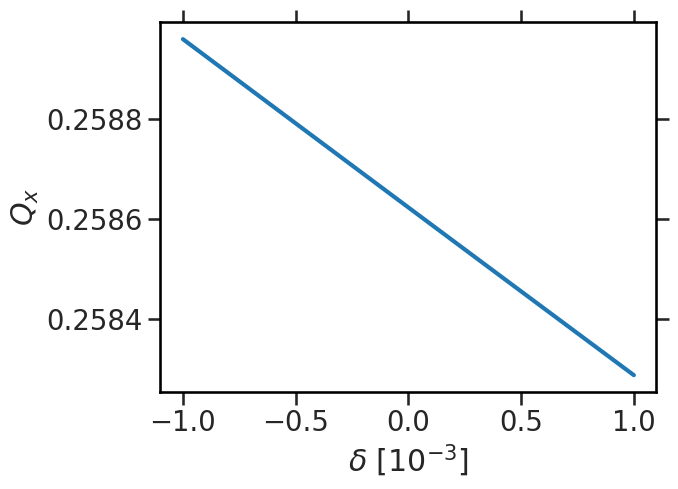

In [56]:
plt.plot(1e3 * delta, Qx_delta)

plt.xlabel('$\delta$ [$10^{-3}$]')
plt.ylabel('$Q_x$');

$\implies$ the tune changes with the momentum, as anticipated! The slope of this line is the first-order chromaticity $Q'_x$!

The `numpy` function `polyfit` is useful for a quick fit, the output is $(a,b)$ for $y=a\cdot x + b$:

In [57]:
np.polyfit(delta, Qx_delta, 1)

array([-0.3360318 ,  0.25862306])

The slope and thus the chromaticity of the LHC FODO cell is approximately $Q'_x=-0.3$, measured via particle tracking. 

#### Comparison

The analytic formula 
$Q'_\text{FODO} = -\frac{1}{\pi}\tan\left(\frac{\Phi_\text{FODO}}{2}\right)$
gives:

In [58]:
-1 / np.pi * np.tan(2 * np.pi * qx_fodo / 2)

-0.32212202611662033

MAD-X would have given us this value, too, we evaluated it as `twiss.summary['dq1'] * beta` (where `beta` is the speed of the particles):

In [59]:
qpx_fodo

-0.32209610180113507

<h2>Chromaticity Correction with Sextupoles</h2>

On average over many turns (during which $\delta$ remains more or less constant, remember synchrotron motion is much slower than tranverse betatron motion), the horizontal position of the particles corresponds to their dispersive closed orbit:
    
$$\langle x \rangle = \langle x_\beta + x_\text{disp}\rangle = \langle \sqrt{2J\beta_x}\underbrace{\cos(\psi_x+\psi_{x0}) }\limits_{\langle\cos\rangle\mathop{=}0}\rangle + \langle D\cdot \delta\rangle = D\cdot \delta$$

Sextupole magnets provide a means to correct for chromaticity in a location where $D(s)\neq 0$ such that particles are on average sorted by momentum $\delta$.

### Bonus Exercise 8: Chromaticity Correction in a FODO Cell

For demonstration, we add sextupoles to the FODO lattice in MAD-X and compute their necessary strength.

Make sure that dipoles are switched on, the dipole angle `theta` should be non-zero:

In [60]:
madx.input('value, theta;')

theta              =     0.005099988074 ;


True

(Otherwise re-run the notebook in order, you need the line `madx.input('theta := 2 * pi / 1232;')`)

We add two sextupole magnets, one next to each quadrupole:

In [61]:
madx.input('sext1: sextupole, l = 1, k2 := k2sext1;')
madx.input('sext2: sextupole, l = 1, k2 := k2sext2;')
madx.command.seqedit(sequence='fodo')
madx.command.install(element='sext1', at=3.3/2 + 1)
madx.command.install(element='sext2', at=110/2 + 3.3/2 + 1)
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  2


True

++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


In [62]:
madx.use('fodo')

In [63]:
madx.input(
'''match, sequence = fodo;
global, sequence = fodo, dq1 = {Qpx}, dq2 = {Qpy};
vary, name = k2sext1, step = 0.0001;
vary, name = k2sext2, step = 0.0001;
lmdif, tolerance = 1e-12;
endmatch;
'''.format(Qpx=0, Qpy=0))

START MATCHING

number of sequences: 1
sequence name: fodo
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:

Initial Penalty Function =   0.20718425E+00


call:       4   Penalty function =   0.68483317E-27
 ++++++++++ LMDIF ended: converged successfully
call:       4   Penalty function =   0.68483317E-27

MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------
Global constraint:         dq1          4     0.00000000E+00     1.11190659E-15     1.23633625E-30
Global constraint:         dq2          4     0.00000000E+00    -2.61456849E-14     6.83596837E-28


Final Penalty Function =   6.84833173e-28





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
k2sext1                   1.27667e-02

True

$\implies$ the iterative algorithm in MAD-X has found suitable values of the sextupole strengths `k2sext1` and `k2sext2` such that the target chromaticity has been corrected to 0.

In [64]:
twiss = madx.twiss();

twiss.summary.dq1

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               110                 -0    0.0004388874913        47.73351305 

                q1                dq1            betxmax              dxmax 
      0.2519723158    1.111906585e-15        186.8781443        2.249453549 

             dxrms             xcomax             xcorms                 q2 
       1.634424445                  0                  0       0.2518947018 

               dq2            betymax              dymax              dyrms 
  -2.614568487e-14        186.4581481                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

1.111906585e-15

$\implies$ the chromaticity from the MAD-X optics computation has really become zero!

We return to the PySixTrack tracking: after adding sextupoles of these strengths and the dipole magnets, we should be able to see the change via evaluating the chromaticity via NAFF from tracking data again!

As a short cut, we make the MAD-X lattice "thin" (apply thin-lens approximation) and transfer the lattice with dipoles and sextupoles to PySixTrack:

In [65]:
assert madx.command.select(
    flag='MAKETHIN',
    class_='quadrupole',
    slice_=1,
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='sextupole',
    slice_=1,
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='sbend',
    slice_=1,
)

madx.command.makethin(
    makedipedge=False,
    style='simple',
    sequence='fodo',
)

fodo_sext = pysixtrack.Line.from_madx_sequence(madx.sequence.fodo)

makethin: style chosen : simple
makethin: slicing sequence : fodo


In [66]:
#for el in fodo_sext.elements:
#    print (el)

Go about with the tracking again:

In [67]:
# define initial particle distribution & prepare recording array
particles = pysixtrack.Particles(x=x_ini, delta=delta)

rec_x = np.zeros((ncells, npart), dtype=float)
rec_x[0] = particles.x

In [68]:
# tracking!
for i in range(1, ncells):
    fodo_sext.track(particles)
    rec_x[i] = particles.x


  Number of warnings: 0

  ++++++++++++++++++++++++++++++++++++++++++++
  +          MAD-X finished normally         +
  ++++++++++++++++++++++++++++++++++++++++++++


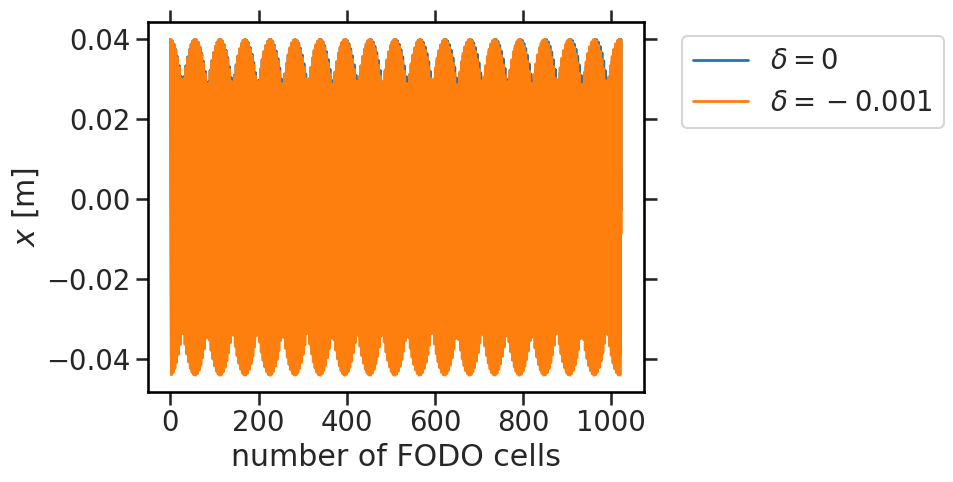

In [69]:
plt.plot(rec_x[:, npart//2 + 1], lw=2, label='$\delta=0$')
plt.plot(rec_x[:, 0], lw=2, label='$\delta=-0.001$')

plt.xlabel('number of FODO cells')
plt.ylabel('$x$ [m]')
plt.legend(bbox_to_anchor=(1.05, 1));

In [70]:
# evaluate tunes via NAFF
Qx_delta = np.zeros(npart, dtype=float)

for i in range(npart):
    Qx_delta[i] = PyNAFF.naff(rec_x[:, i], turns=ncells, nterms=1)[0, 1]

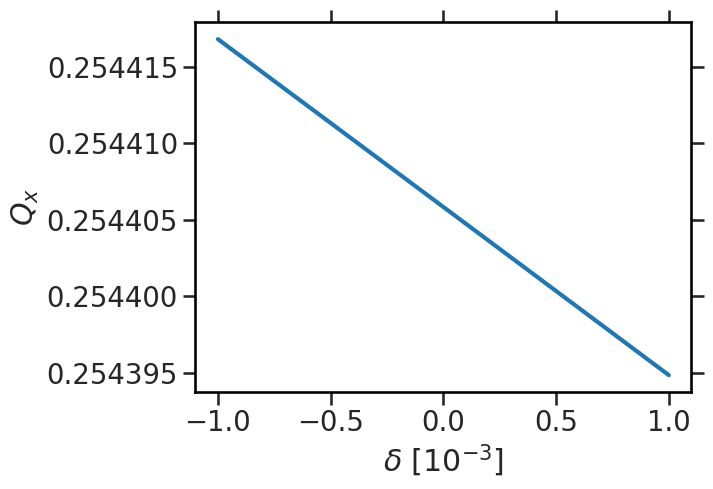

In [71]:
plt.plot(1e3 * delta, Qx_delta)

plt.xlabel('$\delta$ [$10^{-3}$]')
plt.ylabel('$Q_x$');

The fit for the now much flatter slope of the tune change with $\delta$ gives:

In [72]:
np.polyfit(delta, Qx_delta, 1)

array([-0.01098794,  0.25440583])

$\implies$ $Q'_x=-0.01$ is nearly zero, i.e. the chromaticity correction scheme works! (The remainders are due to the thin-lens approximation!)

<i>Hint: we have used 2 sextupoles as 2 degrees of freedom to correct both the horizontal and the vertical chromaticity to zero. One could use only one sextupole degree of freedom, but then only one of the transverse planes can be corrected to $Q'=0$, the other one likely increases!</i>

<h2>Summary</h2>

- Compute Twiss parameters and phase advance from periodic transport matrix
- Betatron matrices and Twiss matrix provide 2 representations of <b>identical</b> solution to Hill differential equation
- Stability of periodic transport matrices
- Optical / Twiss functions and Dispersion of a FODO cell
- Dipoles generate & quadrupoles focuse dispersion function
- Quadrupole focal length depends on momentum, tune change, chromaticity
- Chromatic tune change in a FODO cell
- Correction of chromaticity with sextupole magnets